# Calculate and visualize Harmony's imaging performance

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from drama.io import cfg
from drama.performance.sar import calc_aasr, calc_nesz, RASR, RASRdata, pattern, AASRdata, NESZdata, SARModeFromCfg
from drama.performance.sar.azimuth_performance import mode_from_conf
import drama.geo as geo
from drama.geo.geo_history import GeoHistory
import stereoid.oceans as strocs
import stereoid.utils.config as st_config

# Some instructions
This Notebook computes the SAR imaging performance for Sentinel-1 and the Harmony satellites. The computations are done based on the description of the system in `parfile`. There are three systems of interest:
- Sentinel-1. In principle the performance of S1 does not need to be recalculated, so generally `do_S1=False`
- Harmony Individual Phase Center, which is needed for ATI performance. For this, the SAR performance is based on a single wing antenna. For the `Hrmny_2021_.cfg` file this would be described by the `tud_2020_tripple_ati` section. 
- Harmony Combined Phased Center which in the config file is described by the `tud_2020_tripple` section.
The Harmony performances are also dependent on the along-track separation between the Harmony satellites and Sentinel-1.

If the system parameters or the along-track separation changes, the Notebook needs to be rerun for the two Harmony systems. This is done by setting `do_hrmmy_cpc = True` and then `do_hrmmy_cpc = False`

## Set up the directories and simulation parametrs
main_dir should point to the root directory of the stereoid package. Possible values for mode are "stripmap", "IWS","sliding_spotlight", "EW" and "WM".

In [2]:
do_S1 = False
do_hrmny_cpc = False  # If not we do IPC
rx_ipc_name = 'tud_2020_tripple_ati'
rx_cpc_name = 'tud_2020_tripple'
parfile_name = 'Hrmny_2021_1.cfg'
do_aasrs_S1 = True and do_S1
do_neszs_S1 = True and do_S1
do_rasrs_S1 = True and do_S1

In [3]:
# General setup
paths = st_config.parse(section="Paths")
main_dir = paths["main"]

datadir = paths["data"]
patterdir = datadir / "PATTERNS"
if do_hrmny_cpc:
    rxname = rx_cpc_name
else:
    rxname = rx_ipc_name
txname = 'sentinel'
# Next two lines are for Sentinel-1 performance
# rxname = 'sentinel' 
# For companions, is_bistatic should be True
is_bistatic = True
runid = '2021_1'

pardir = paths["par"]
pltdirr = paths["results"] / "Activation" / runid
parfile = pardir / parfile_name
conf = cfg.ConfigFile(parfile)
# extract relevant info from conf
rxcnf = getattr(conf, rxname)
txcnf = getattr(conf, txname)
if is_bistatic:
    dau_km = int(conf.formation_primary.dau[0] / 1e3)
else:
    dau_km = int(0)
dau_str = ("%ikm" % dau_km)
indstr = rxname
sysid = indstr # ("%s_%3.2fm" % (indstr, b_at))
if rxcnf.DBF:
    sysid = sysid + "_DBF"
    
if rxcnf.SCORE:
    sysid = sysid + "_SCORE"

savedirr = paths["results"] / "SARPERF" / sysid
savedirr = savedirr / dau_str
mode = "IWS"
Nswth = 3
n_az_pts = 11
inc_range=[10,45]
(incs, PRFs, proc_bw,
 steering_rates,
 burst_lengths, short_name, proc_tap, tau_p, bw_p) = mode_from_conf(conf, mode)

In [8]:
type(conf)

drama.io.cfg.ConfigFile

# Set up Sentinel-1 parameters

In [32]:
# S1 setup
rx_S1 = "sentinel"
tx_S1 = "sentinel"
# extract relevant info from conf
rxcnf = getattr(conf, rx_S1)
txcnf = getattr(conf, tx_S1)
dau_km_S1 = int(0)
dau_str = ("%ikm" % dau_km_S1)
indstr = rx_S1
sysid = indstr
if rxcnf.DBF:
    sysid = sysid + "_DBF"
    
if rxcnf.SCORE:
    sysid = sysid + "_SCORE"

savedirr_S1 = paths["results"] / "SARPERF" / sysid / dau_str

# Calculate ambiguities
## Sentinel-1

GeoHistory -- Total initialization time: 1.258987
calc_aasr -- Compute Patterns
calc_aasr -- Steering rates: 0.027758, 0.027758
calc_aasr: nor burt times given, calculating them from burst length
GeoHistory -- Total initialization time: 1.249232
calc_aasr -- Compute Patterns
calc_aasr -- Steering rates: 0.017102, 0.017102
calc_aasr: nor burt times given, calculating them from burst length
GeoHistory -- Total initialization time: 1.312462
calc_aasr -- Compute Patterns
calc_aasr -- Steering rates: 0.024389, 0.024389
calc_aasr: nor burt times given, calculating them from burst length


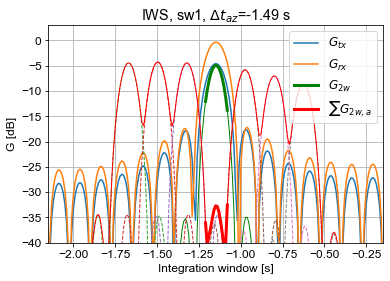

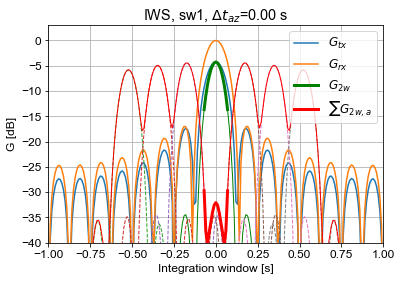

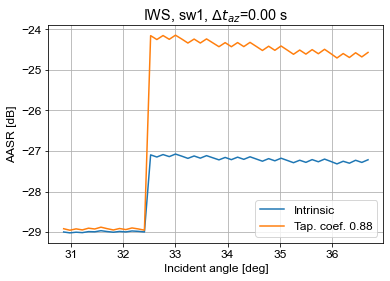

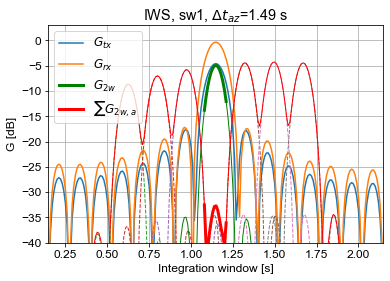

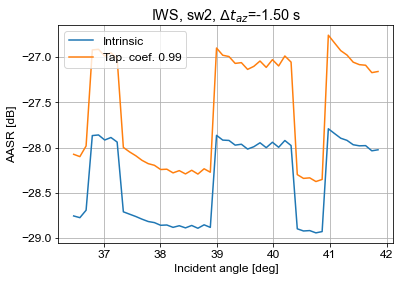

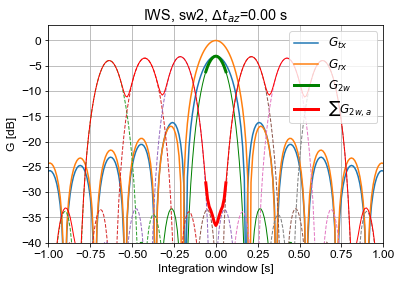

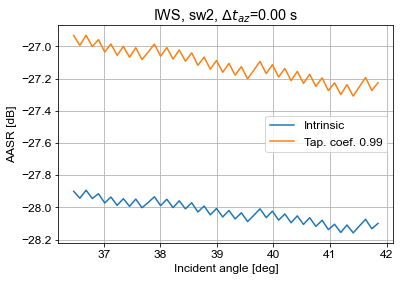

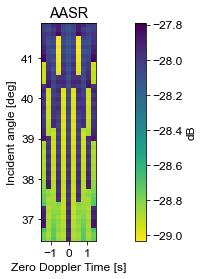

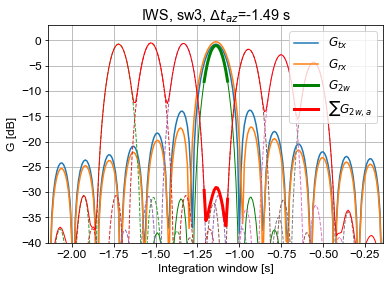

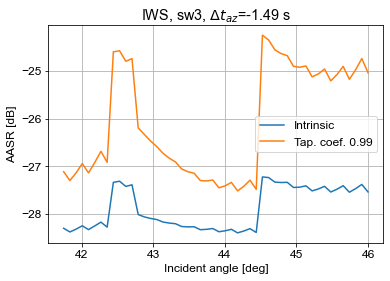

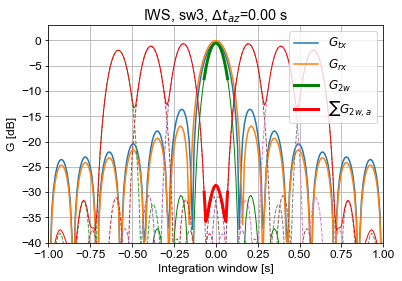

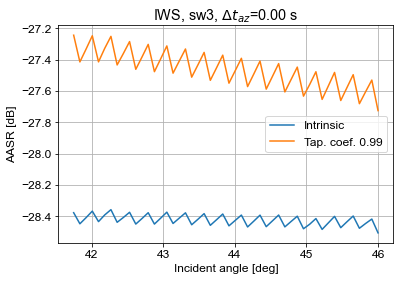

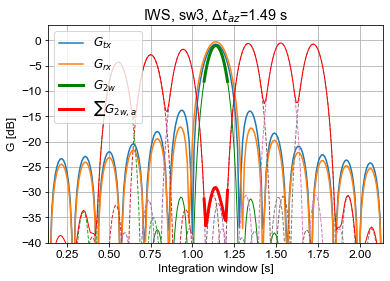

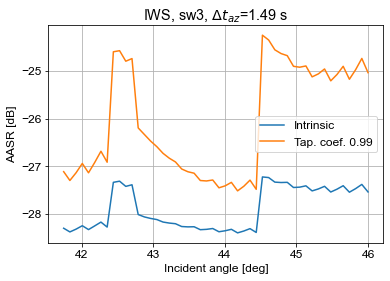

In [36]:

aasrs_S1 = []
aasr_files_S1 = []
for swth in range(Nswth):
    modeandswth = ("%s_sw%i" % (short_name, swth + 1))
    modedir_S1 = os.path.join(savedirr_S1, modeandswth)
    aasr_files_S1.append(os.path.join(modedir_S1,'aasr.p'))
    if do_aasrs_S1:
        aasr_ = calc_aasr(conf, mode, swth,
                          txname=tx_S1,
                          rxname=rx_S1,
                          savedirr=savedirr_S1,
                          t_in_bs=None,
                          n_az_pts=n_az_pts,
                          view_patterns=False,
                          Tanalysis=10,
                          az_sampling=100, Namb=3,
                          bistatic=False)
        aasr_.save(os.path.join(modedir_S1,'aasr.p'))
    else:
        aasr_ = AASRdata.from_file(os.path.join(modedir_S1,'aasr.p'))
    aasrs_S1.append(aasr_)

    
aasr_S1 = AASRdata.from_filelist(aasr_files_S1) 
aasr_S1.save(os.path.join(savedirr_S1, "%s_AASR.p" % short_name))
aasr_S1 = AASRdata.from_file(os.path.join(savedirr_S1, "%s_AASR.p" % short_name))

## Harmony

GeoHistory -- Total initialization time: 4.203185
calc_aasr -- Compute Patterns
calc_aasr -- Steering rates: 0.027758, 0.021930
calc_aasr: nor burt times given, calculating them from burst length
GeoHistory -- Total initialization time: 3.701053
calc_aasr -- Compute Patterns
calc_aasr -- Steering rates: 0.017102, 0.013635
calc_aasr: nor burt times given, calculating them from burst length
GeoHistory -- Total initialization time: 3.785153
calc_aasr -- Compute Patterns
calc_aasr -- Steering rates: 0.024389, 0.019589
calc_aasr: nor burt times given, calculating them from burst length


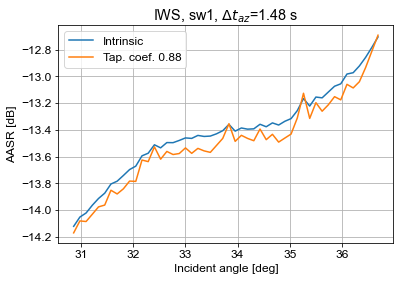

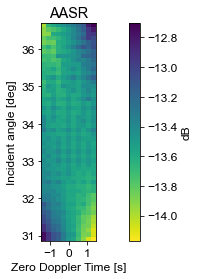

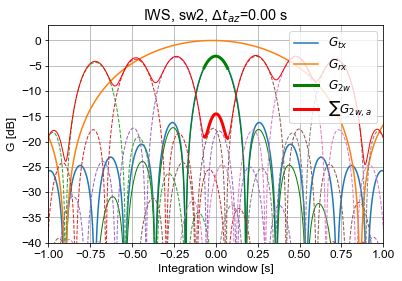

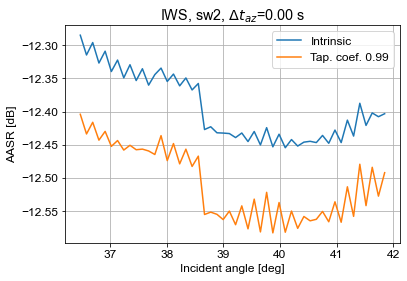

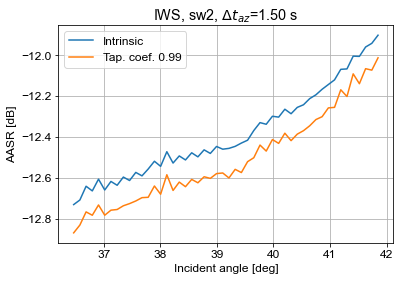

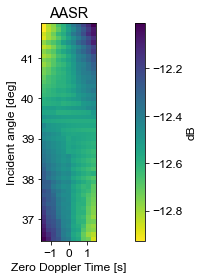

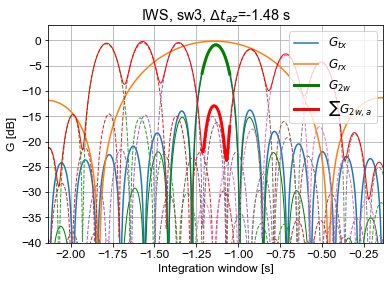

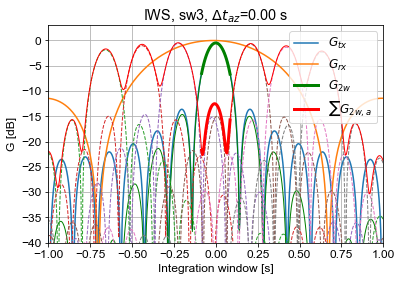

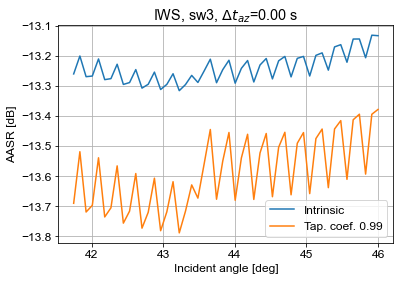

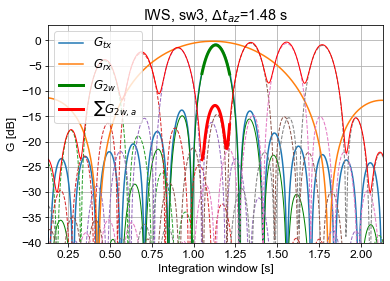

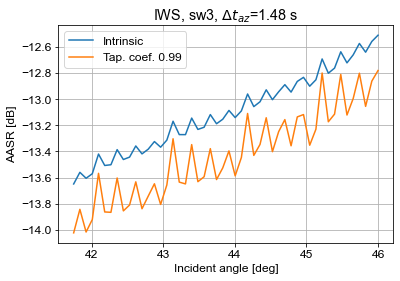

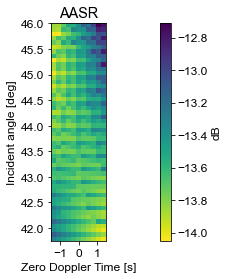

In [9]:
do_aasrs = True

aasrs = []
aasr_files = []
for swth in range(Nswth):
    modeandswth = ("%s_sw%i" % (short_name, swth + 1))
    modedir = os.path.join(savedirr, modeandswth)
    aasr_files.append(os.path.join(modedir,'aasr.p'))
    if do_aasrs:
        aasr_ = calc_aasr(conf, mode, swth,
                          txname='sentinel',
                          rxname=rxname,
                          savedirr=savedirr,
                          t_in_bs=None,
                          n_az_pts=n_az_pts,
                          view_patterns=False,
                          Tanalysis=20,
                          # vmin=-25.0, vmax=-15.0,
                          az_sampling=200, Namb=3,
                          bistatic=is_bistatic)
        aasr_.save(os.path.join(modedir,'aasr.p'))
    else:
        aasr_ = AASRdata.from_file(os.path.join(modedir,'aasr.p'))
    aasrs.append(aasr_)

    # plt.figure()
    # plt.imshow(aasr_.dsr_amb[:, :, 2])
    # plt.colorbar()
    # plt.show()
    
    # plt.figure()
    # plt.imshow(aasr_.dt_amb[:, :, 2])
    # plt.colorbar()
    # plt.show()

aasr = AASRdata.from_filelist(aasr_files)   
aasr.save(os.path.join(savedirr, "%s_AASR.p" % short_name))
aasr = AASRdata.from_file(os.path.join(savedirr, "%s_AASR.p" % short_name))

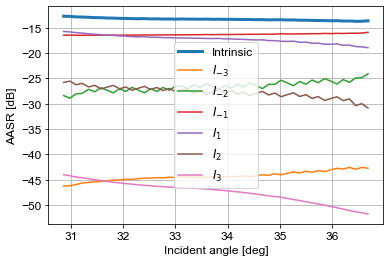

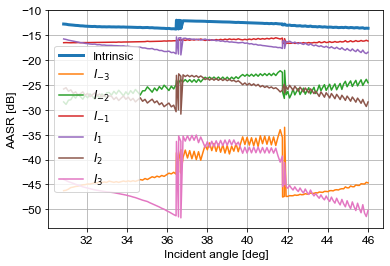

In [10]:
aasrs[0].plot_aasr(burst_ind=1, tapered=False)
#print(aasrs[0].dt_amb[0,25])
#print(aasrs[0].aasr_par[0, 25])
aasr.plot_aasr(burst_ind=1, tapered=False)

# NESZ

## Sentinel-1

calc_nesz -- Time bandwidth: 2960.60
GeoHistory -- Total initialization time: 1.328045
calc_nesz -- calc_nesz: nor burt times given, calculating them from burst length
calc_nesz -- Time bandwidth: 2994.60
GeoHistory -- Total initialization time: 1.329704
calc_nesz -- calc_nesz: nor burt times given, calculating them from burst length
calc_nesz -- Time bandwidth: 2285.52
GeoHistory -- Total initialization time: 1.488912
calc_nesz -- calc_nesz: nor burt times given, calculating them from burst length


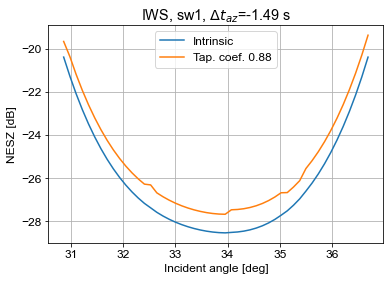

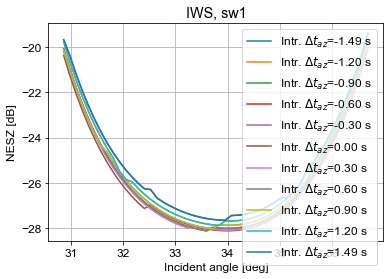

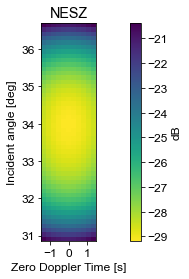

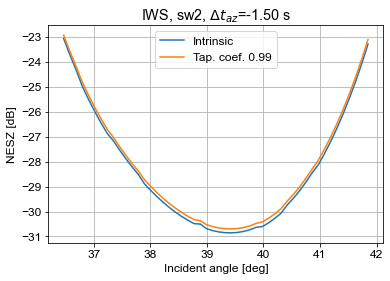

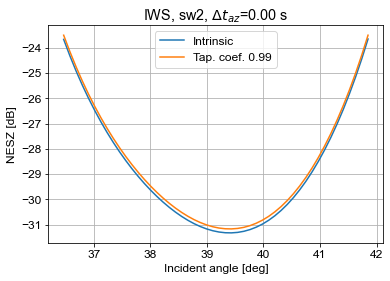

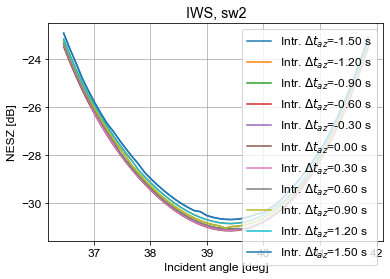

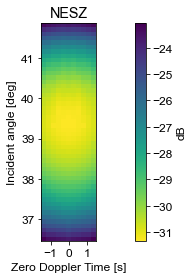

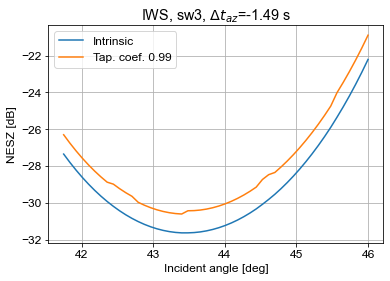

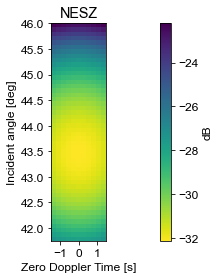

In [37]:

neszs_S1 = []
nesz_files_S1 = []
for swth in range(Nswth):
    modeandswth = ("%s_sw%i" % (short_name, swth + 1))
    modedir_S1 = os.path.join(savedirr_S1, modeandswth)
    nesz_files_S1.append(os.path.join(modedir_S1,'nesz.p'))
    if do_neszs_S1:
        nesz_ = calc_nesz(conf, mode, swth, txname=tx_S1,
                          rxname=rx_S1,
                          savedirr=savedirr_S1,
                          t_in_bs=None,
                          n_az_pts=n_az_pts,
                          extra_losses=rxcnf.L,
                          Tanalysis=10,
                          az_sampling=200, bistatic=False)
        nesz_.save(os.path.join(modedir_S1,'nesz.p'))
    else:
        nesz_ = NESZdata.from_file(os.path.join(modedir_S1,'nesz.p'))
    neszs_S1.append(nesz_)

nesz_S1 = NESZdata.from_filelist(nesz_files_S1)
nesz_S1.save(os.path.join(savedirr_S1, "%s_NESZ.p" % short_name))
nesz_S1 = NESZdata.from_file(os.path.join(savedirr_S1, "%s_NESZ.p" % short_name))

## Harmony

calc_nesz -- Time bandwidth: 2960.60
GeoHistory -- Total initialization time: 3.668768
calc_nesz -- calc_nesz: nor burt times given, calculating them from burst length
calc_nesz -- Time bandwidth: 2994.60
GeoHistory -- Total initialization time: 4.180630
calc_nesz -- calc_nesz: nor burt times given, calculating them from burst length
calc_nesz -- Time bandwidth: 2285.52
GeoHistory -- Total initialization time: 4.063142
calc_nesz -- calc_nesz: nor burt times given, calculating them from burst length


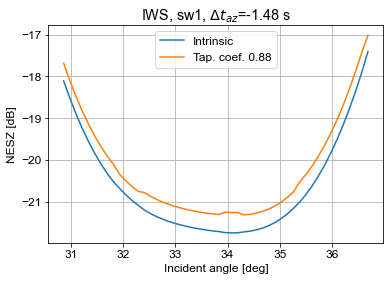

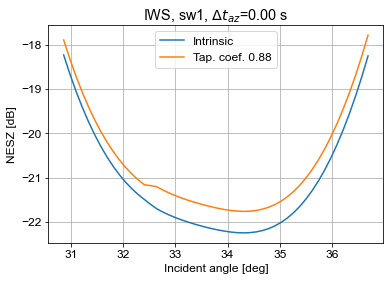

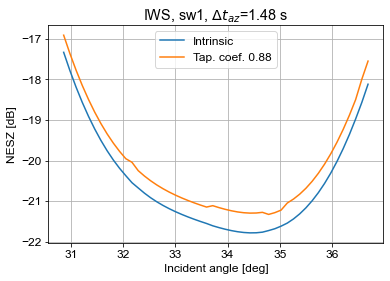

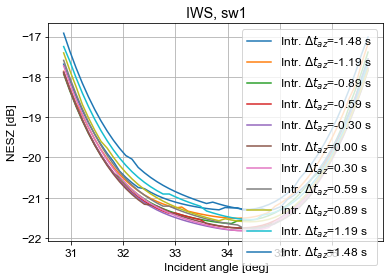

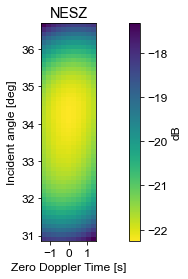

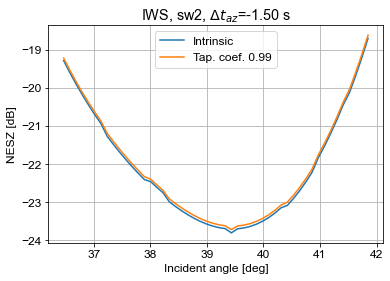

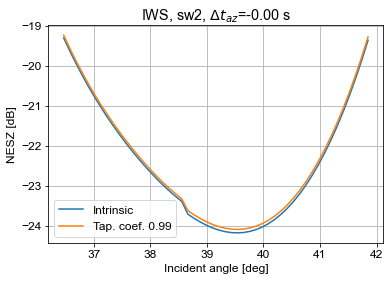

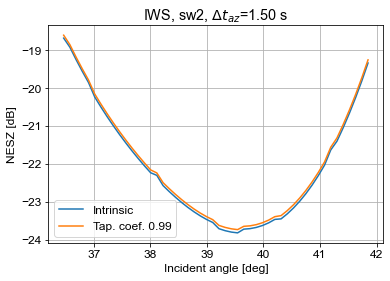

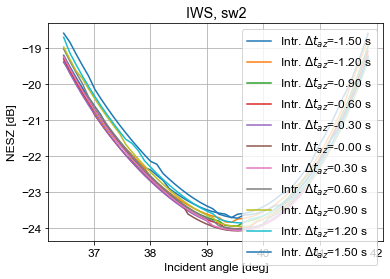

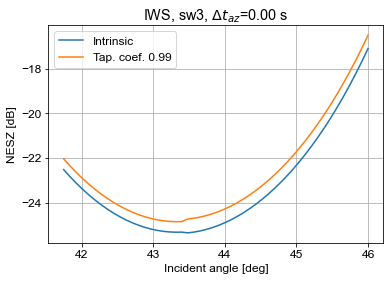

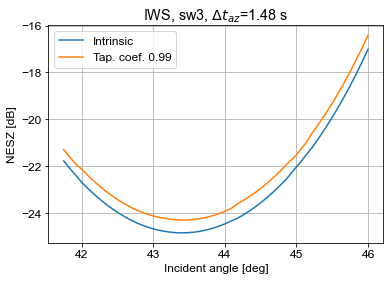

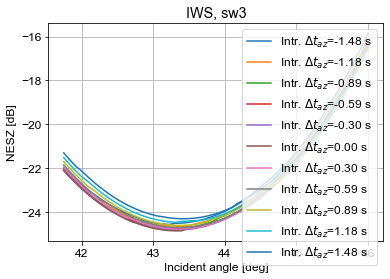

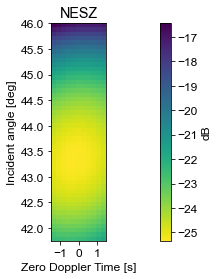

In [11]:
do_neszs = True
neszs = []
nesz_files = []
for swth in range(Nswth):
    modeandswth = ("%s_sw%i" % (short_name, swth + 1))
    modedir = os.path.join(savedirr, modeandswth)
    nesz_files.append(os.path.join(modedir,'nesz.p'))
    if do_neszs:
        nesz_ = calc_nesz(conf, mode, swth, txname='sentinel',
                          rxname=rxname,
                          savedirr=savedirr,
                          t_in_bs=None,
                          n_az_pts=n_az_pts,
                          extra_losses=rxcnf.L,
                          Tanalysis=10,
                          az_sampling=200, bistatic=is_bistatic)
        nesz_.save(os.path.join(modedir,'nesz.p'))
    else:
        nesz_ = NESZdata.from_file(os.path.join(modedir,'nesz.p'))
    neszs.append(nesz_)

nesz = NESZdata.from_filelist(nesz_files)
nesz.save(os.path.join(savedirr, "%s_NESZ.p" % short_name))
nesz = NESZdata.from_file(os.path.join(savedirr, "%s_NESZ.p" % short_name))

# RASR

## Sentinel-1

In [ ]:

rasrs_S1 = []
rasrs_files_S1 = []
for swth in range(0, Nswth):
    modeandswth = ("%s_sw%i" % (short_name, swth + 1))
    modedir_S1 = os.path.join(savedirr_S1, modeandswth)
    rasrs_files_S1.append(os.path.join(modedir_S1,'rasr.p'))
    if do_rasrs_S1:
        rasr_ = RASR(conf, mode, swth, txname=tx_S1,
                     rxname=rx_S1,
                     savedirr=savedirr_S1,
                     t_in_bs=None,
                     n_az_pts=n_az_pts, n_amb_az=1, Tanalysis=5,
                     az_sampling=100, bistatic=False, verbosity=1)
        rasr_.save(os.path.join(modedir_S1,'rasr.p'))
    else:
        rasr_ = RASRdata.from_file(os.path.join(modedir_S1,'rasr.p'))
    rasrs_S1.append(rasr_)

rasr_S1 = RASRdata.from_filelist(rasrs_files_S1)
rasr_S1.save(os.path.join(savedirr_S1, "%s_RASR.p" % short_name))
rasr_S1 = RASRdata.from_file(os.path.join(savedirr_S1, "%s_RASR.p" % short_name))

In [ ]:
rasr_S1.calc_rasr()
print(rasr_S1.rasr_parcial.shape)
plt.figure()
plt.plot(rasr_S1.inc_v, 10*np.log10(rasr_S1.rasr_total[0]))
plt.grid(True)

## Harmony

In [7]:
do_rasrs = True
rasrs = []
rasr_files = []
for swth in range(0, Nswth):
    modeandswth = ("%s_sw%i" % (short_name, swth + 1))
    modedir = os.path.join(savedirr, modeandswth)
    rasr_files.append(os.path.join(modedir,'rasr.p'))
    if do_rasrs:
        rasr_ = RASR(conf, mode, swth, txname='sentinel',
                     rxname=rxname,
                     savedirr=savedirr,
                     t_in_bs=None,
                     Namb=1,
                     n_az_pts=n_az_pts, n_amb_az=5, Tanalysis=10,
                     az_sampling=100, bistatic=is_bistatic, verbosity=1)
        rasr_.save(os.path.join(modedir,'rasr.p'))
    else:
        rasr_ = RASRdata.from_file(os.path.join(modedir,'rasr.p'))
    rasrs.append(rasr_)

rasr = RASRdata.from_filelist(rasr_files)
rasr.save(os.path.join(savedirr, "%s_RASR.p" % short_name))
rasr = RASRdata.from_file(os.path.join(savedirr, "%s_RASR.p" % short_name))

GeoHistory -- Total initialization time: 4.805151
RASR -- calc_rasr: nor burt times given, calculating them from burst length
GeoHistory -- Total initialization time: 3.767386
RASR -- calc_rasr: nor burt times given, calculating them from burst length


ValueError: A value in x_new is below the interpolation range.

In [ ]:
print(rasr_files)
rasr.calc_rasr()
print(rasr.rasr_parcial.shape)
plt.figure()
plt.plot(rasr.inc_v, 10*np.log10(np.transpose(rasr.rasr_parcial[5,:,0,:])))
plt.grid(True)

# Doppler uncertainties
The following cells do not really belong in this Notebook other than as an example of use of the SAR performances.

In [ ]:
ati_perf = strocs.ATIPerf(nesz, 6, 2e3)

In [ ]:
nesz.plot_nesz()
inc = nesz.inc_v[1:]
plt.figure()
plt.plot(inc, ati_perf.sigma_vdop(inc, -20))
plt.grid(True)

In [ ]:
dca_perf = strocs.DCAPerf(nesz, 6, 1e3, tx_name='sentinel', rx_name='sentinel')

In [ ]:
plt.figure()
plt.plot(inc, dca_perf.sigma_vdop(inc, -10 + np.zeros_like(inc)))
plt.grid(True)

In [ ]:
7e3/300